In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import sys; sys.path.insert(0, '..')
from src.data import analyze_data
import src.config as config

In [11]:
# Load data
data = pd.read_csv(config.data_path_renamed)
target = config.target

In [12]:
# General analysis
data.describe()

,nitrogen,phosphorus,potassium,temperature,humidity,ph_value,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [13]:
data

,nitrogen,phosphorus,potassium,temperature,humidity,ph_value,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,Coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,Coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,Coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,Coffee


As we can see below, there are no null entries, all the feature columns are numerical and the target column is categorical.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nitrogen     2200 non-null   int64  
 1   phosphorus   2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph_value     2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


Let us now look at the distribution for each column

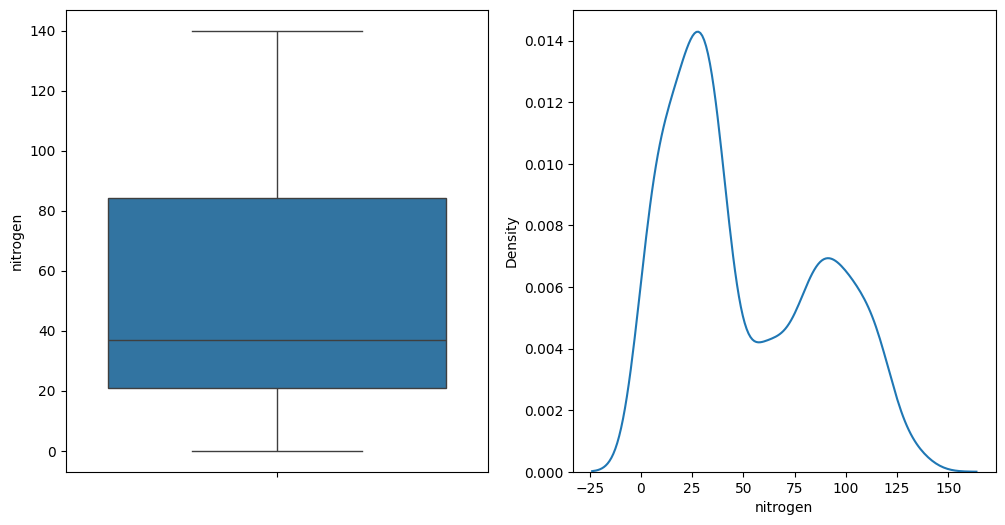

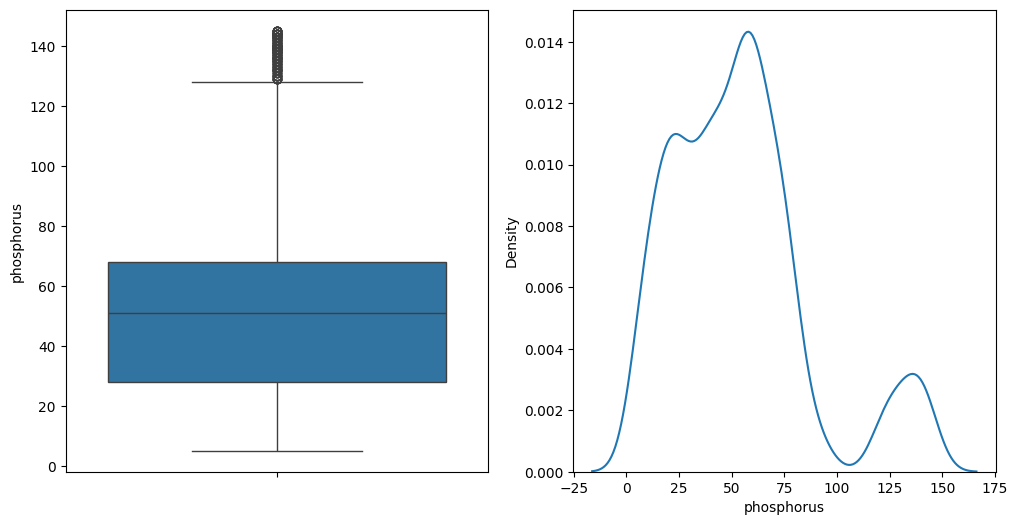

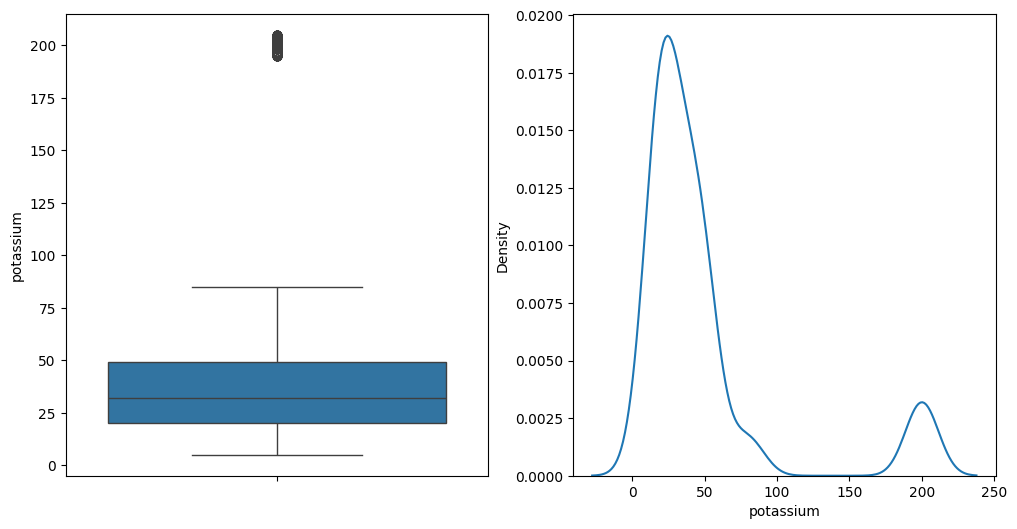

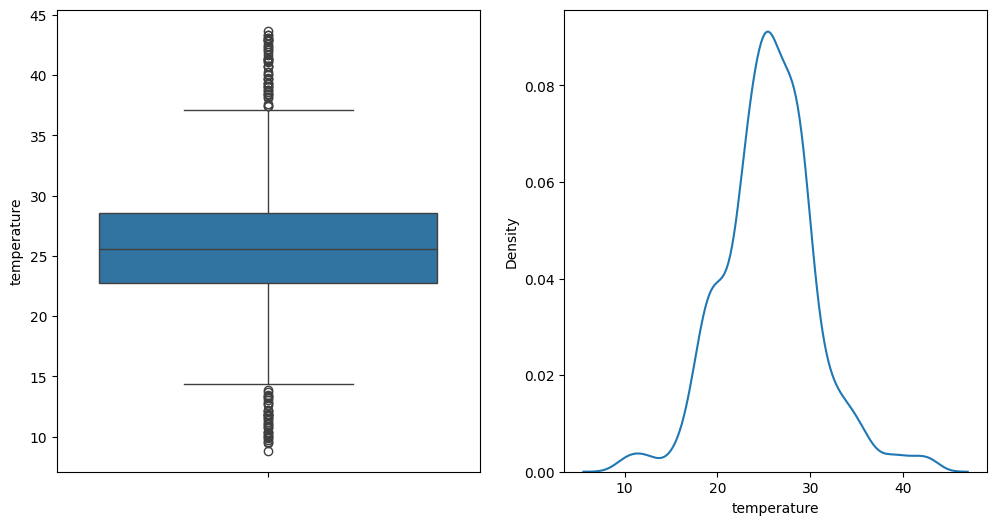

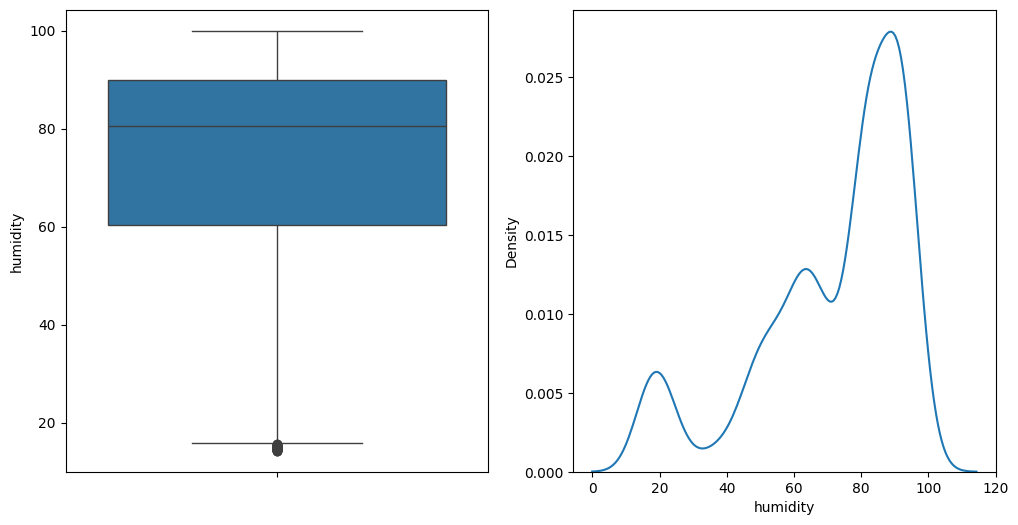

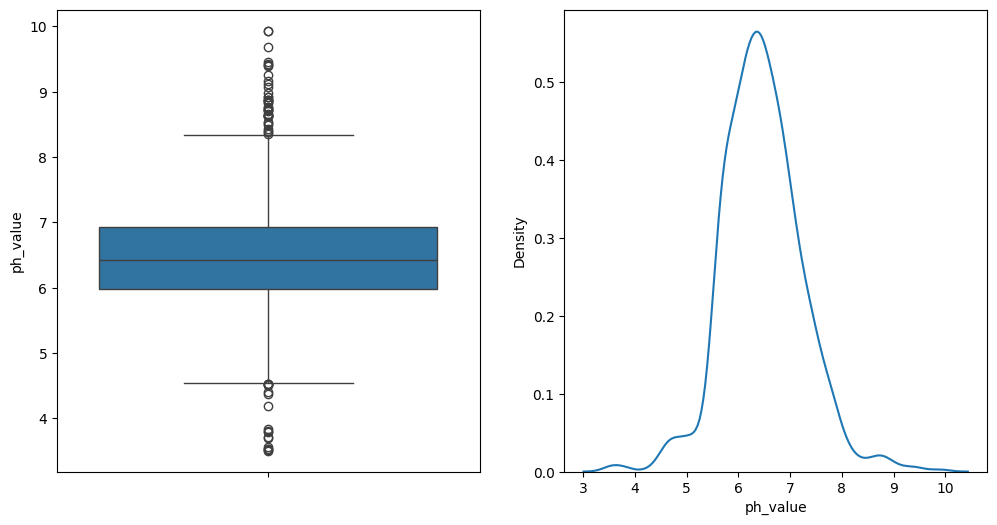

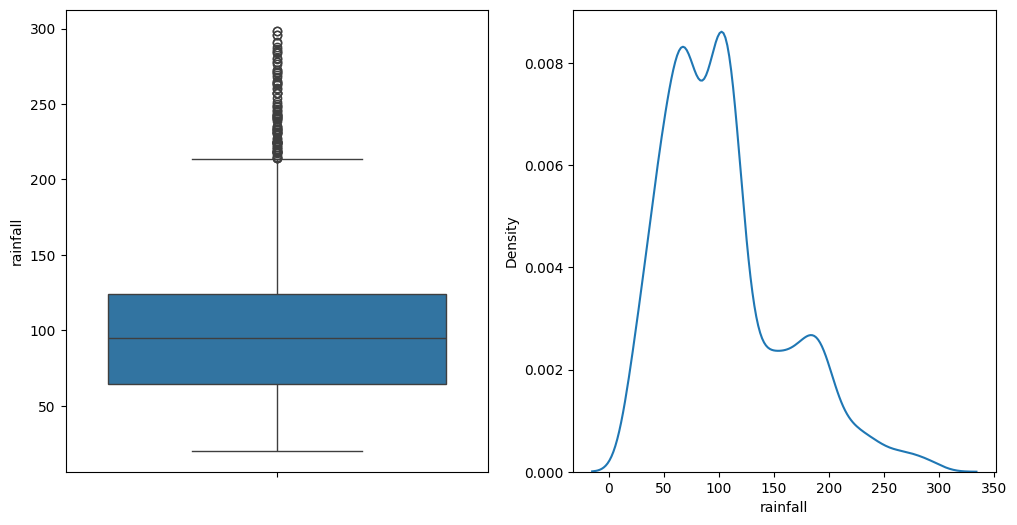

In [15]:
for col in data.drop([target], axis=1).columns:
    fig, axs = plt.subplots(ncols=2, figsize=(12,6))
    sns.boxplot(data, y=col, ax=axs[0])
    sns.kdeplot(data, x=col, ax=axs[1])

A few comments are in order:

1. Nitrogen presents an asymmetrical bimodal distribution with few outliers.
2. Phosphorus has a near bimodal Gaussian distribution with a small pocket of outliers above.
3. Potassium has a near Gaussian distribution with a small pocket of outliers above.
4. Temperature, pH value are near Gaussian with some outliers on both sides
5. Humidity, Rainfaill are skewed distributions with large spread.

We see below that the proportion of outliers is below 10% for all the columns. As a first approach it does not seem necessary to regularize these since none of them seem erroneous.

In [16]:
ratio_outliers = {}
for col in data.drop([target],axis=1).columns:
    outlier_below, outlier_above = analyze_data.is_outlier(data[col])
    n_outliers = (outlier_above | outlier_below).sum()
    ratio_outliers[col] = n_outliers/data[col].count()

ratio_outliers = pd.Series(ratio_outliers).sort_values(ascending=False)
print(ratio_outliers)

potassium      0.090909
phosphorus     0.062727
rainfall       0.045455
temperature    0.039091
ph_value       0.025909
humidity       0.013636
nitrogen       0.000000
dtype: float64


Let us now look at the effect of the target on the distribution of each feature. We first see the values of the target are balanced, as we would expect from an artificial dataset.

In [17]:
data.groupby([target])["nitrogen"].count()

crop
Apple          100
Banana         100
Blackgram      100
ChickPea       100
Coconut        100
Coffee         100
Cotton         100
Grapes         100
Jute           100
KidneyBeans    100
Lentil         100
Maize          100
Mango          100
MothBeans      100
MungBean       100
Muskmelon      100
Orange         100
Papaya         100
PigeonPeas     100
Pomegranate    100
Rice           100
Watermelon     100
Name: nitrogen, dtype: int64

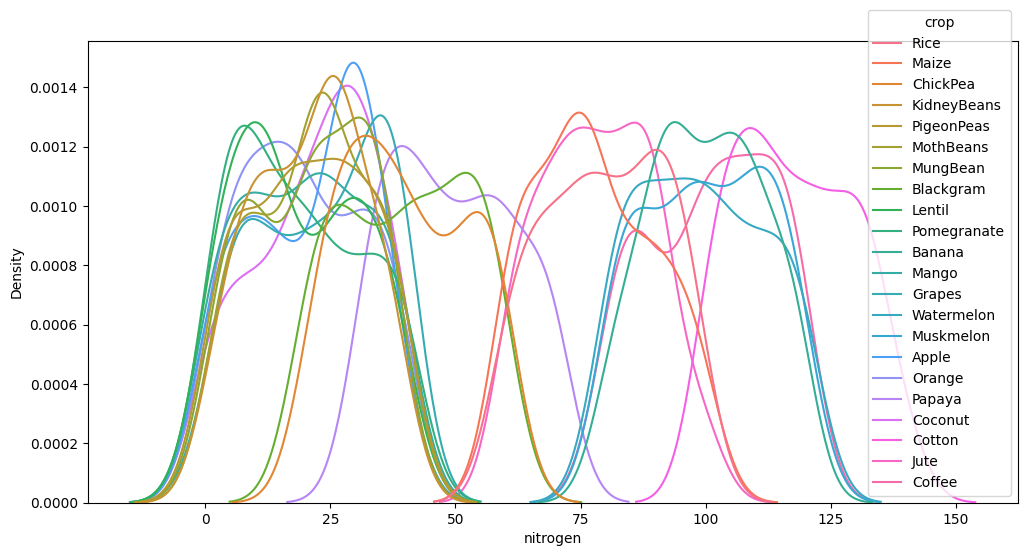

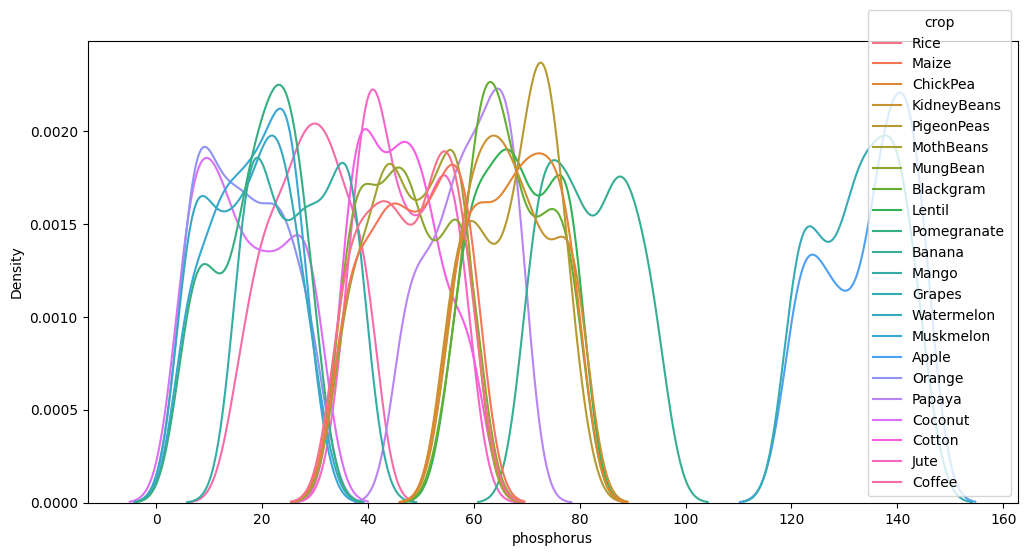

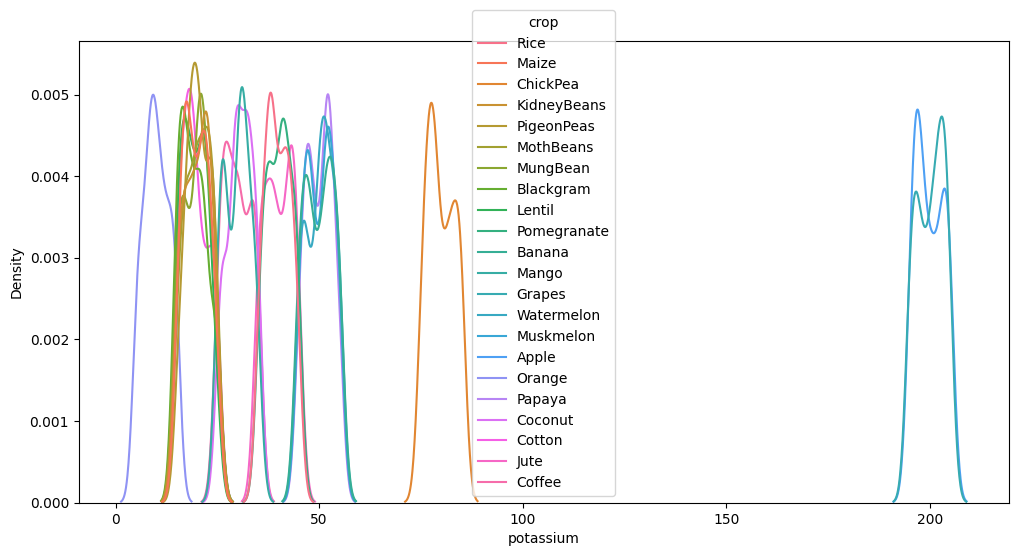

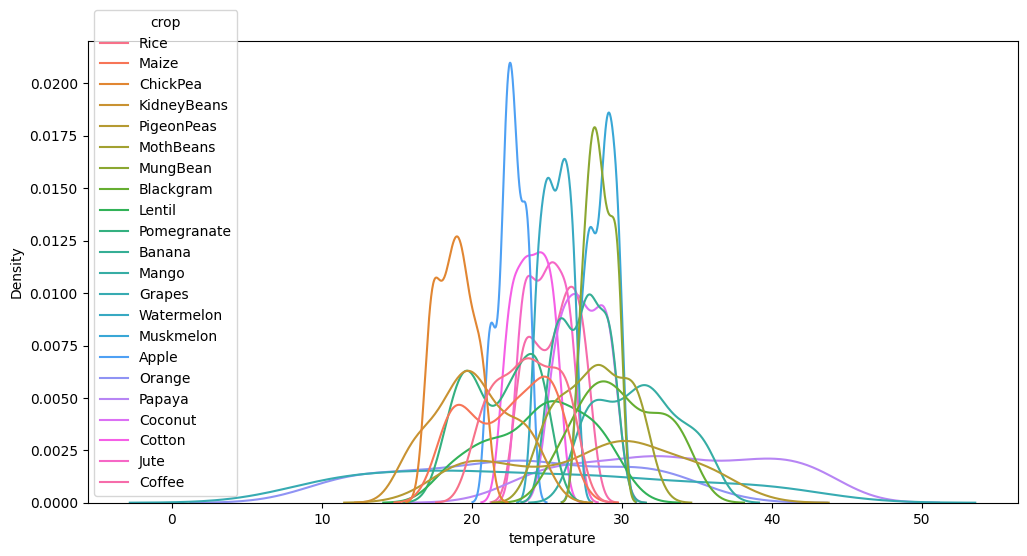

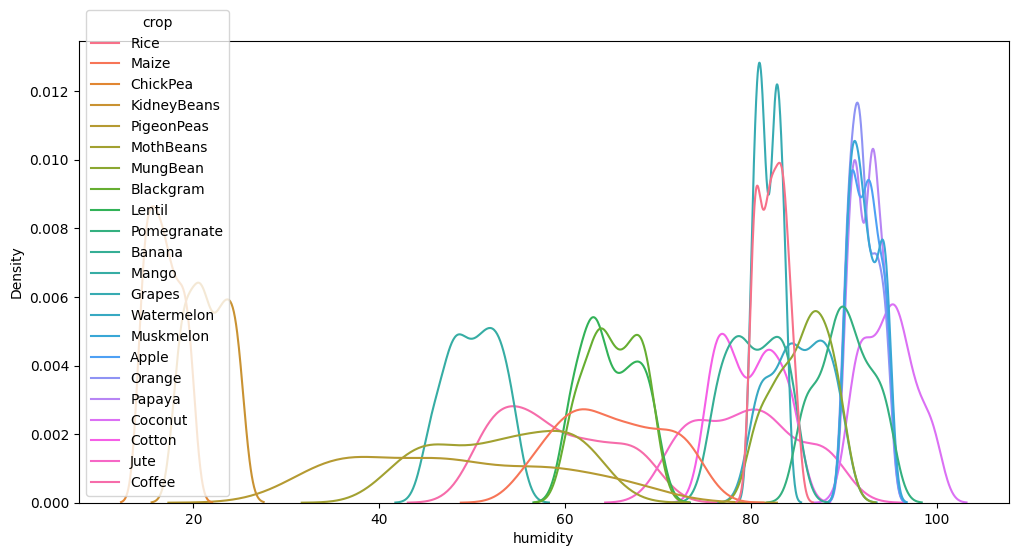

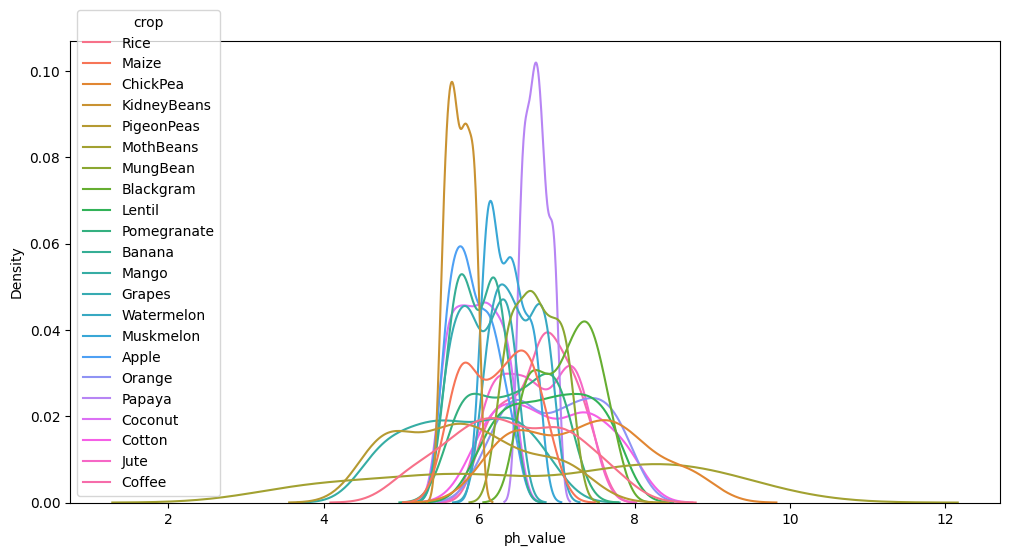

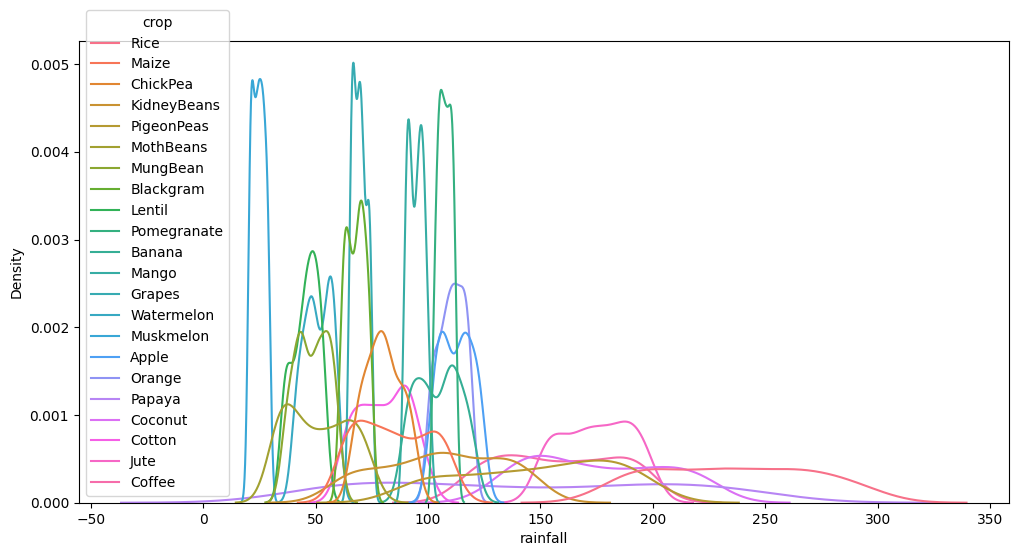

In [18]:
for col in data.drop([target], axis=1).columns:
    fig, axs = plt.subplots(ncols=1, figsize=(12,6))
    sns.kdeplot(data, x=col, ax=axs, hue=target)

The number of categorical values for the target obscures the grouping of the target per feature, however there are two possible features one can clearly engineer to improve models:
1. In the `potassium` and `phosphorus` features, we see the two outliers region account for two labels which can help.
2. In various features such as `phosphorus`, `potassium`, `humidity`, the various target values only have support over a small range. Binning these columns can help distinguish which target value is more likely.

Now let us look at whether any feature shows correlation:

<Axes: >

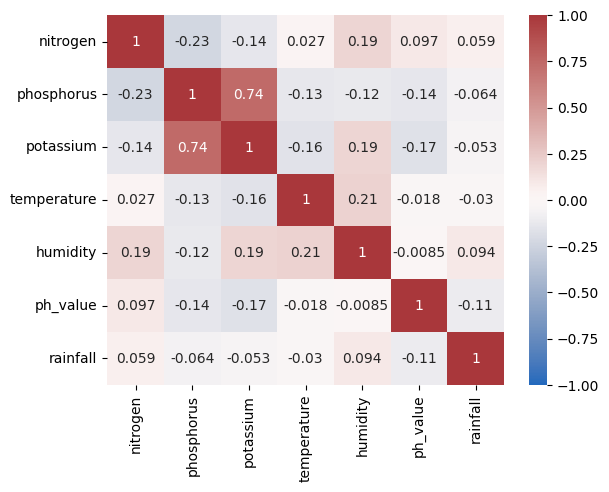

In [19]:
sns.heatmap(
    data.drop([target], axis=1).corr(), 
    vmin=-1, 
    vmax=1, 
    cmap="vlag",
    annot=True
)

First we see that `phosphorus` and `potassium` are strongly correlated, which we can check by plotting them together. We see a indeed a very linear trend.

<Axes: xlabel='potassium', ylabel='phosphorus'>

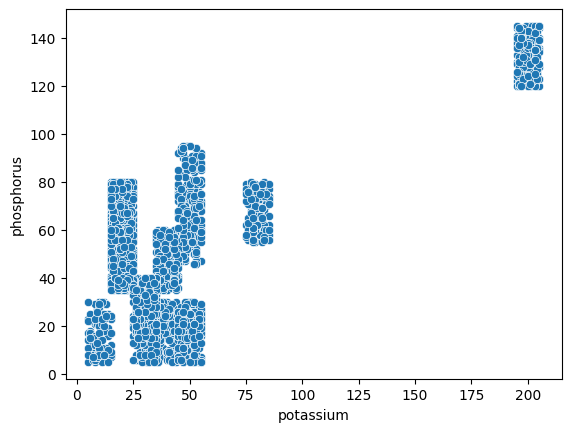

In [20]:
sns.scatterplot(data, x="potassium", y="phosphorus")

We see that in spite of higher than average correlations, `humidity` is not clearly correlated with `nitrogen` or `temperature`.

<Axes: xlabel='temperature', ylabel='humidity'>

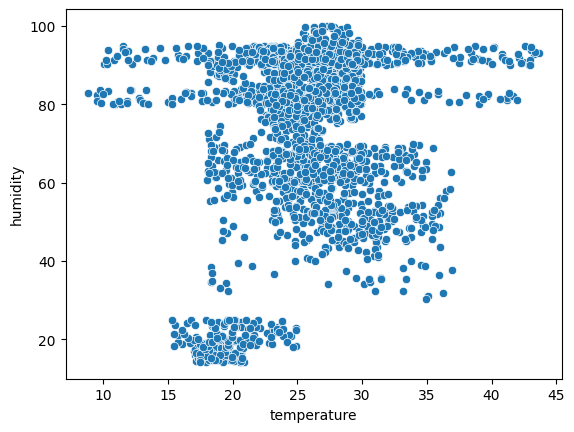

In [21]:
sns.scatterplot(data, x="temperature", y="humidity")

<Axes: xlabel='nitrogen', ylabel='humidity'>

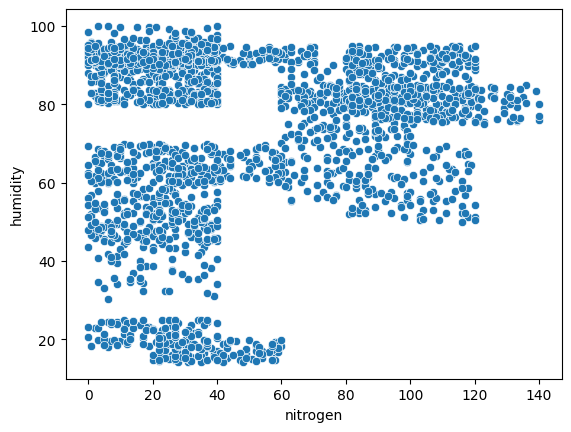

In [22]:
sns.scatterplot(data, x="nitrogen", y="humidity")

Finally, let us look into correlations to the target. To do so, we need to temporarily encode the labels of the target column. We start with label encoding to find general correlations.

In [23]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [24]:
y_target_label = pd.Series(LabelEncoder().fit_transform(data[target]))

In [25]:
data.drop(labels=[target], axis=1).corrwith(y_target_label).sort_values(ascending=False)

humidity       0.193911
temperature    0.113606
rainfall       0.045611
ph_value      -0.012253
nitrogen      -0.031130
potassium     -0.346417
phosphorus    -0.491006
dtype: float64

Here again we confirm our previous intuition: the features most correlated with the target are those for which each target value has a well-defined support on the value of the feature.

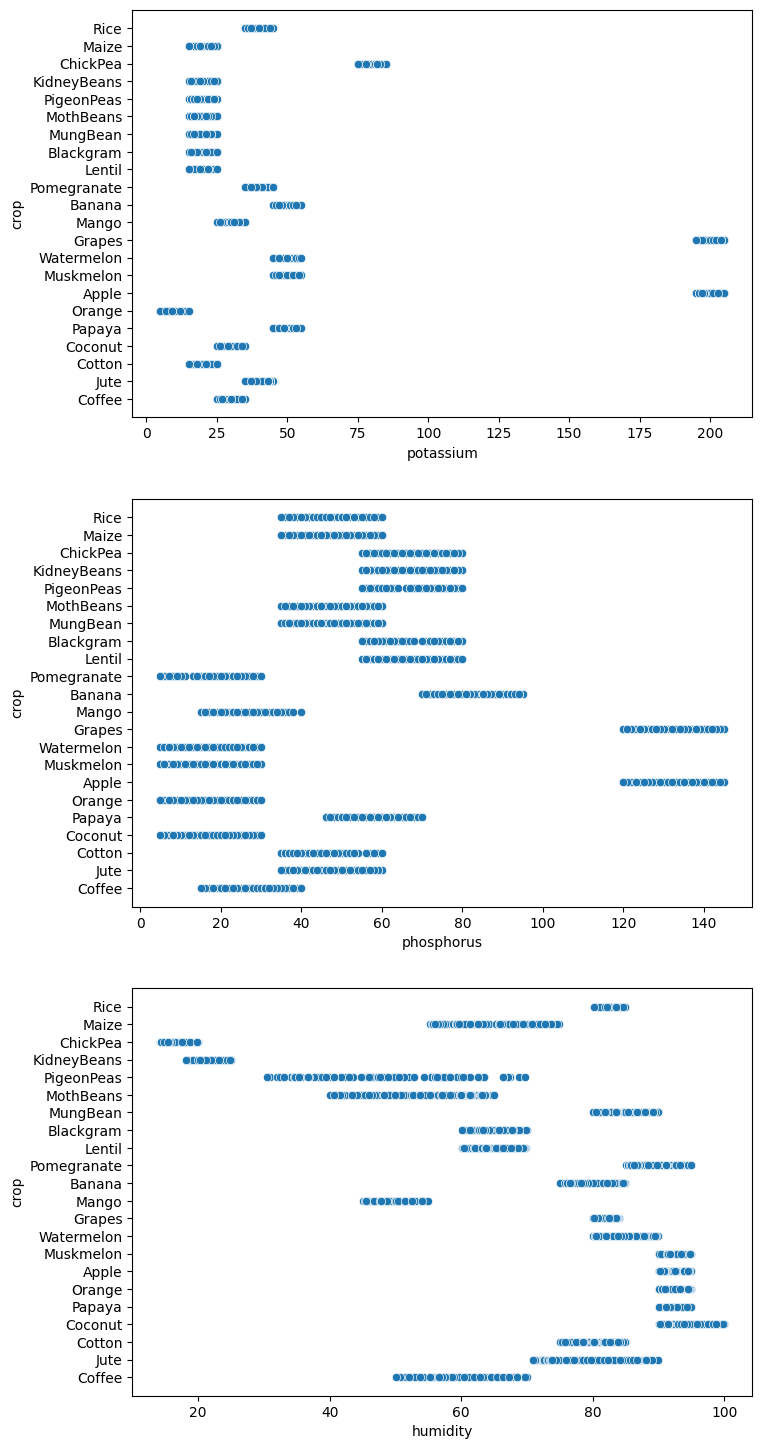

In [26]:
fig,axs = plt.subplots(nrows=3, figsize=(8,18))
for i,col in enumerate(["potassium", "phosphorus", "humidity"]):
    sns.scatterplot(data, x=col, y=target, ax=axs[i])